In [30]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import Helper.Preprocessing as pp 
import Helper.Model_dense as ml 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Log return?

In [31]:
log_return = False

# Explore data


In [67]:
df = pd.read_csv("Data/dataset.csv", sep=",")
df.Date = pd.to_datetime(df.Date)
# df = df[df.Date >= pd.to_datetime('2015-01-26')]
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,SARON_close,US_IR,CH_infl,US_infl
0,2005-01-03,1.1378,1.1550,1.1374,1.1470,1.1470,0.0,"0,588191","1,99","-0,5","0,21019443"
1,2005-01-04,1.1471,1.1706,1.1443,1.1676,1.1676,0.0,"0,616042","2,05","-0,5","0,21019443"
2,2005-01-05,1.1676,1.1754,1.1655,1.1669,1.1669,0.0,"0,696835","2,04","-0,5","0,21019443"


In [68]:
Close =  df.Close
US_infl = df.US_infl.apply(lambda x: x.replace(',', '.')).astype(float)
CH_infl = df.CH_infl.apply(lambda x: x.replace(',', '.')).astype(float)
US_IR = df.US_IR.apply(lambda x: x.replace(',', '.')).astype(float)
SARON_close = df.SARON_close.apply(lambda x: x.replace(',', '.')).astype(float)
data = [Close, US_infl, CH_infl,US_IR, SARON_close]

Futures

In [69]:
# df_fut = pd.read_csv("Data/Swiss Franc Futures Historical Data.csv", sep=",")
# df_fut.Date = pd.to_datetime(df_fut.Date)

# plt.plot(df_fut.Date, df_fut.Price, )
# plt.plot(df.Date, 1/df.Close, '--')
# plt.grid()

In [70]:
# Log return

def get_log_ret(df_):
    ret = df_.shift(1) / df_
    ret.replace([np.inf, np.nan, -np.inf], 0, inplace=True)
    log_ret = np.log(ret)
    log_ret.replace([np.inf, np.nan, -np.inf], 0, inplace=True)
    return log_ret.iloc[1:]

if log_return:
    data = [Close, US_IR, SARON_close, US_infl, CH_infl]
    for i in range(3): 
      data[i] = get_log_ret(data[i])

    for i in range(3,5): 
      data[i] = data[i].iloc[1:]

    fig = plt.figure(figsize=(15, 7))

    name  = ['Close log return','US_IR log return', 'SARON_close log return', 'US_infl', 'CH_infl']
    for i in range(5):   
        plt.subplot(1,5,1+i)
        plt.hist(data[i], bins=150)
        plt.title(name[i])
    plt.tight_layout()
    plt.show()

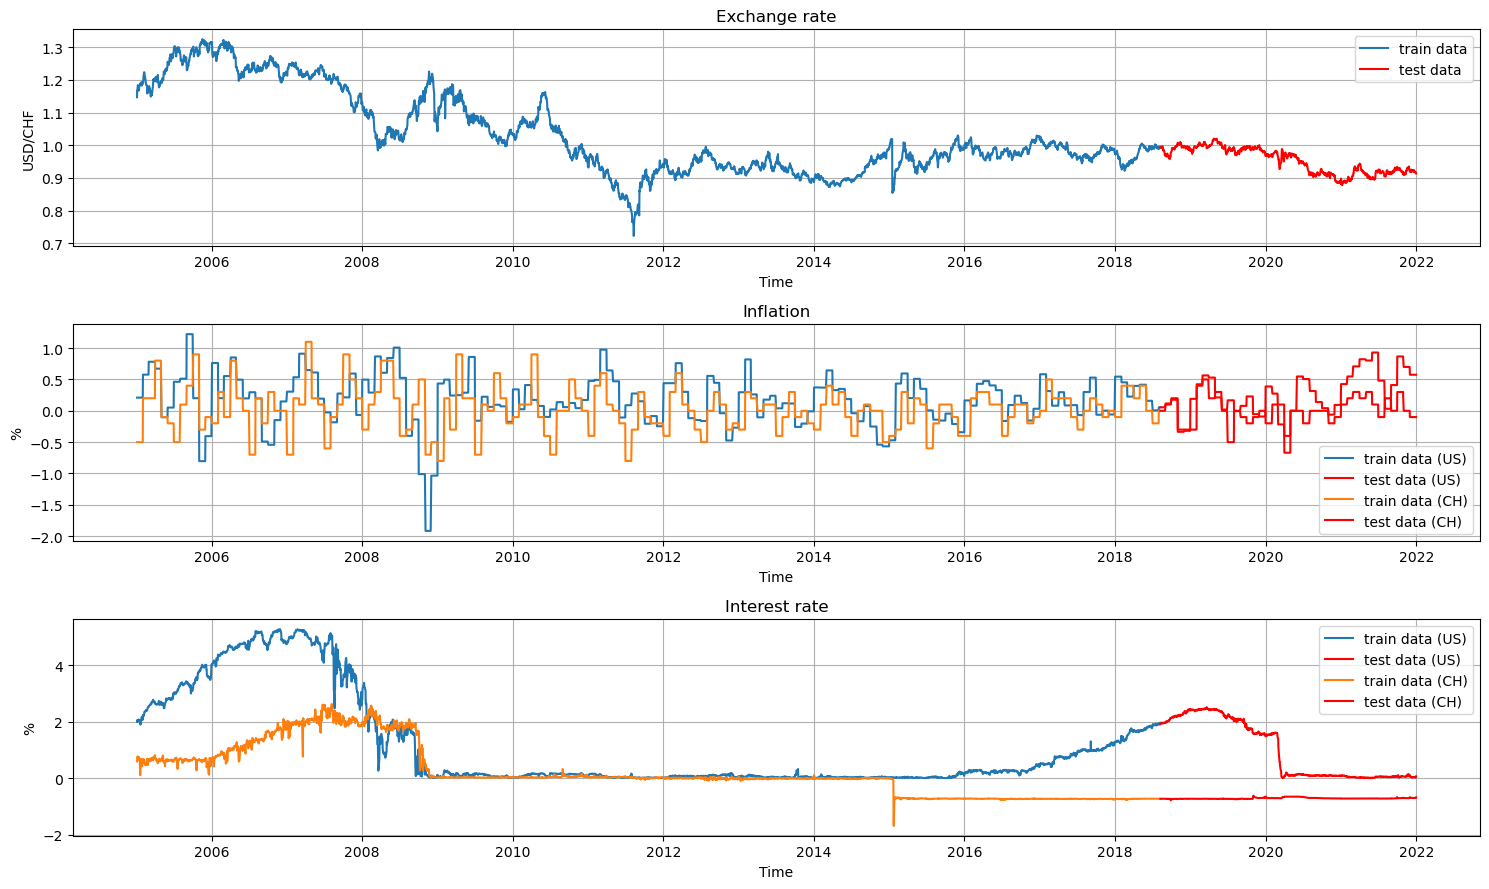

In [71]:
FRACTION_TEST = 0.2
nb_test = int(FRACTION_TEST*len(df))

plt.figure(figsize=(15, 9))

plt.subplot(3,1,1)
plt.title("Exchange rate")
plt.plot(df.Date.values[:-nb_test],df.Close.values[:-nb_test], label="train data")
plt.plot(df.Date.values[-nb_test:], df.Close.values[-nb_test:], color="r", label="test data")
plt.xlabel("Time", fontsize=10)
plt.ylabel("USD/CHF", fontsize=10)
plt.grid()
plt.legend(fontsize=10)

plt.subplot(3,1,2)
plt.title("Inflation")
plt.plot(df.Date.values[:-nb_test],US_infl.values[:-nb_test], label="train data (US)")
plt.plot(df.Date.values[-nb_test:], US_infl.values[-nb_test:], color="r", label="test data (US)")
plt.plot(df.Date.values[:-nb_test],CH_infl.values[:-nb_test], label="train data (CH)")
plt.plot(df.Date.values[-nb_test:], CH_infl.values[-nb_test:], color="r", label="test data (CH)")
plt.xlabel("Time", fontsize=10)
plt.ylabel("%", fontsize=10)
plt.grid()
plt.legend(fontsize=10)

plt.subplot(3,1,3)
plt.title("Interest rate")
plt.plot(df.Date.values[:-nb_test],US_IR.values[:-nb_test], label="train data (US)")
plt.plot(df.Date.values[-nb_test:], US_IR.values[-nb_test:], color="r", label="test data (US)")
plt.plot(df.Date.values[:-nb_test],SARON_close.values[:-nb_test], label="train data (CH)")
plt.plot(df.Date.values[-nb_test:], SARON_close.values[-nb_test:], color="r", label="test data (CH)")
plt.xlabel("Time", fontsize=10)
plt.ylabel("%", fontsize=10)
plt.grid()
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Dataset

In [52]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=10, norm_=False, fraction_val_=0.2, fraction_test_=FRACTION_TEST)

if log_return:
    data = [Close, US_IR, SARON_close, US_infl, CH_infl]
    train_x_rate, val_x_rate, test_x_rate, train_y_rate, val_y_rate, test_y_rate, norm = pp.generate_dataset(data, lookback_=4, norm_=False, fraction_val_=0.2, fraction_test_=FRACTION_TEST)
    
    train_y_rate = train_y_rate[:,0]
    val_y_rate = val_y_rate[:,0]
    test_y_rate = test_y_rate[:,0]

Shape:         
X train     (1150, 10, 5), y train     (1150, 5)        
X train val (288, 10, 5) , y train val (288, 5)         
X test      (362, 10, 5) , y test      (362, 5)


Decide which features to consider !!!!!!

In [53]:
variables = [0,3,4]

train_x = train_x[:,:,variables]
val_x = val_x[:,:,variables]
test_x = test_x[:,:,variables]

print(train_x[0])

[[ 0.8811    0.02     -0.726632]
 [ 0.9013    0.02     -0.755313]
 [ 0.8992    0.02     -0.748131]
 [ 0.907     0.01     -0.697963]
 [ 0.9225    0.01     -0.678498]
 [ 0.9213    0.01     -0.675273]
 [ 0.9271    0.02     -0.702567]
 [ 0.92475   0.01     -0.721958]
 [ 0.926     0.02     -0.715027]
 [ 0.922     0.01     -0.71407 ]]


Reshape for NN input

In [54]:
train_x = train_x.reshape(train_x.shape[0], -1)
print(train_x.shape)

val_x = val_x.reshape(val_x.shape[0], -1)
print(val_x.shape)

test_x = test_x.reshape(test_x.shape[0], -1)
print(test_x.shape)

(1150, 30)
(288, 30)
(362, 30)


In [55]:
train_y = train_y[:,0]
val_y = val_y[:,0]
test_y = test_y[:,0]

# Generate model

In [56]:
model = ml.dense_model(num_layers = 4, layer_size = 64, input_size = train_x.shape[1], output_size = 1, dropout=0.2)
model

dense_model(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [57]:
batch_size = 512
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [58]:
device = 'cpu'
num_epochs = 400
criterion_reg = nn.MSELoss()   

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_loss = []
val_loss = []
loss_log = np.ones(10)

for epoch in tqdm.tqdm(range(1, num_epochs+1)):
    avg_loss = 0.
    model.train()

    for x, label in train_loader:
        outputs = model(x.to(device).float())
        optimizer.zero_grad()

        loss = criterion_reg(outputs, label.to(device).float().unsqueeze(1))
        avg_loss += loss.item()
        loss.backward()

        optimizer.step()
    
    # Training loss
    train_loss.append(avg_loss/(len(train_loader)))

    # Validation loss
    model.eval()
    inp = torch.from_numpy(np.array(val_x))
    labs = torch.from_numpy(np.array(val_y))
    out = model(inp.to(device).float())
    outputs = out.cpu().detach().numpy()
    targets = labs.numpy().reshape(-1)
    MSE = np.mean((outputs-targets)**2)
    # MSE = criterion_reg(outputs, targets.reshape(-1,1))
    val_loss.append(MSE)

    if epoch % (num_epochs/10) == 0:
        print("Epoch: %d,\nloss MSE: %f" % (epoch, train_loss[-1])) 
        print("Validation loss MSE: %f" % (val_loss[-1])) 
        
    # Termination
    # loss_log = np.delete(loss_log, 0)
    # loss_log = np.append(loss_log, train_loss[-1])
    # if epoch > 10 and abs((loss_log[-1]-loss_log[0])/loss_log[0]) < 0.2:
    #     break

 11%|█         | 43/400 [00:02<00:17, 19.98it/s]

Epoch: 40,
loss MSE: 0.034843
Validation loss MSE: 0.005239


 20%|██        | 82/400 [00:04<00:20, 15.31it/s]

Epoch: 80,
loss MSE: 0.022854
Validation loss MSE: 0.001899


 31%|███       | 124/400 [00:07<00:14, 18.44it/s]

Epoch: 120,
loss MSE: 0.015957
Validation loss MSE: 0.000726


 41%|████      | 163/400 [00:09<00:13, 17.78it/s]

Epoch: 160,
loss MSE: 0.011890
Validation loss MSE: 0.000806


 51%|█████     | 204/400 [00:11<00:12, 16.04it/s]

Epoch: 200,
loss MSE: 0.009435
Validation loss MSE: 0.001095


 61%|██████▏   | 245/400 [00:13<00:05, 28.19it/s]

Epoch: 240,
loss MSE: 0.008172
Validation loss MSE: 0.000956


 70%|███████   | 281/400 [00:15<00:05, 20.98it/s]

Epoch: 280,
loss MSE: 0.006993
Validation loss MSE: 0.000959


 81%|████████  | 323/400 [00:17<00:04, 16.25it/s]

Epoch: 320,
loss MSE: 0.005915
Validation loss MSE: 0.001533


 91%|█████████ | 363/400 [00:20<00:02, 16.52it/s]

Epoch: 360,
loss MSE: 0.006258
Validation loss MSE: 0.001045


100%|██████████| 400/400 [00:22<00:00, 18.02it/s]

Epoch: 400,
loss MSE: 0.005628
Validation loss MSE: 0.001147


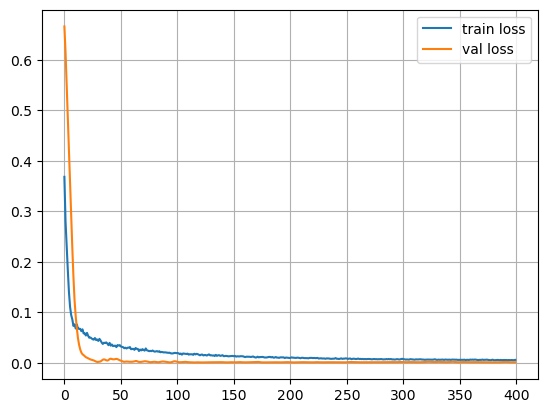

In [59]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.grid()
plt.legend()
plt.show()

In [60]:
def evaluate(model, x_, y_):
    model.eval()

    outputs = []
    targets = []
    
    inp = torch.from_numpy(np.array(x_))
    labs = torch.from_numpy(np.array(y_))

    out = model(inp.to(device).float())
    outputs = out.cpu().detach().numpy()
    targets = labs.numpy().reshape(-1)

    outputs = out.cpu().detach().numpy()
    targets = labs.numpy()

    MSE = np.mean((outputs-targets)**2)
    print("MSE: {}".format(MSE))
    return outputs, targets, MSE

In [63]:
outputs1, targets1, MSE = evaluate(model, test_x, test_y)

MSE: 0.007304944147340344


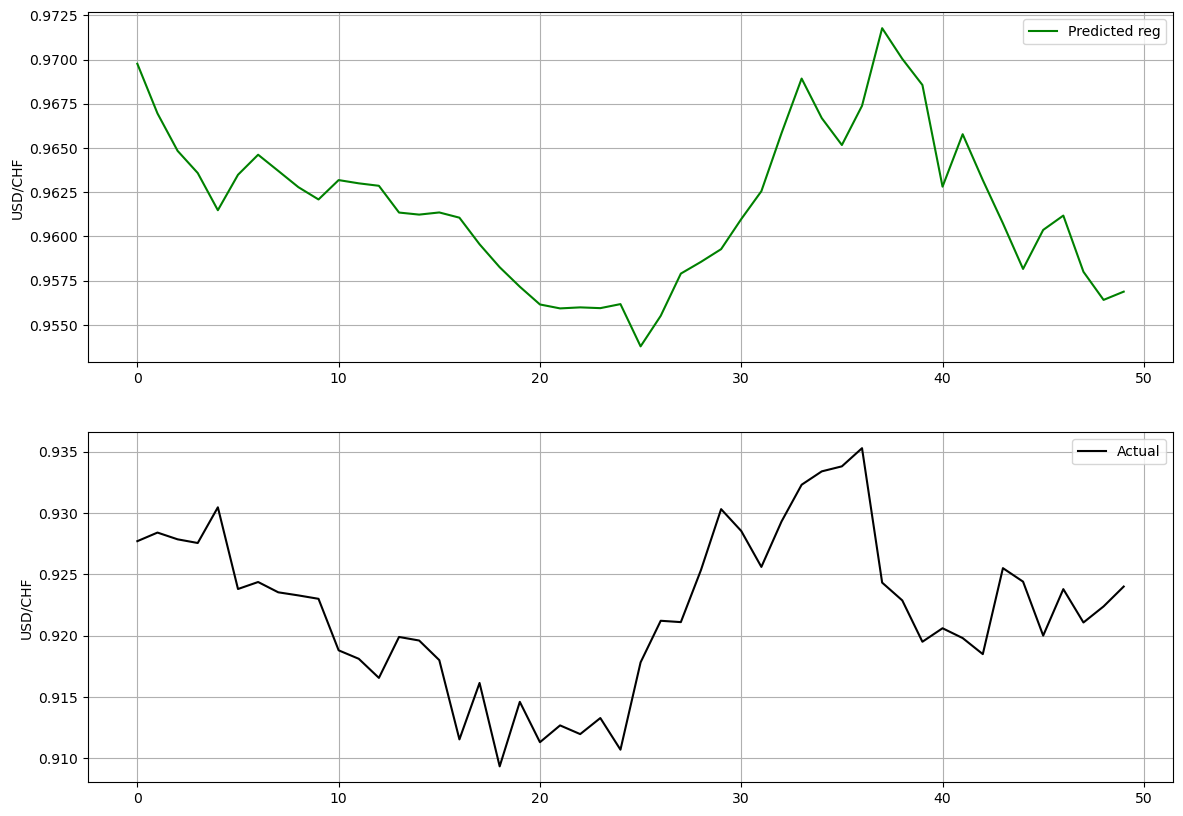

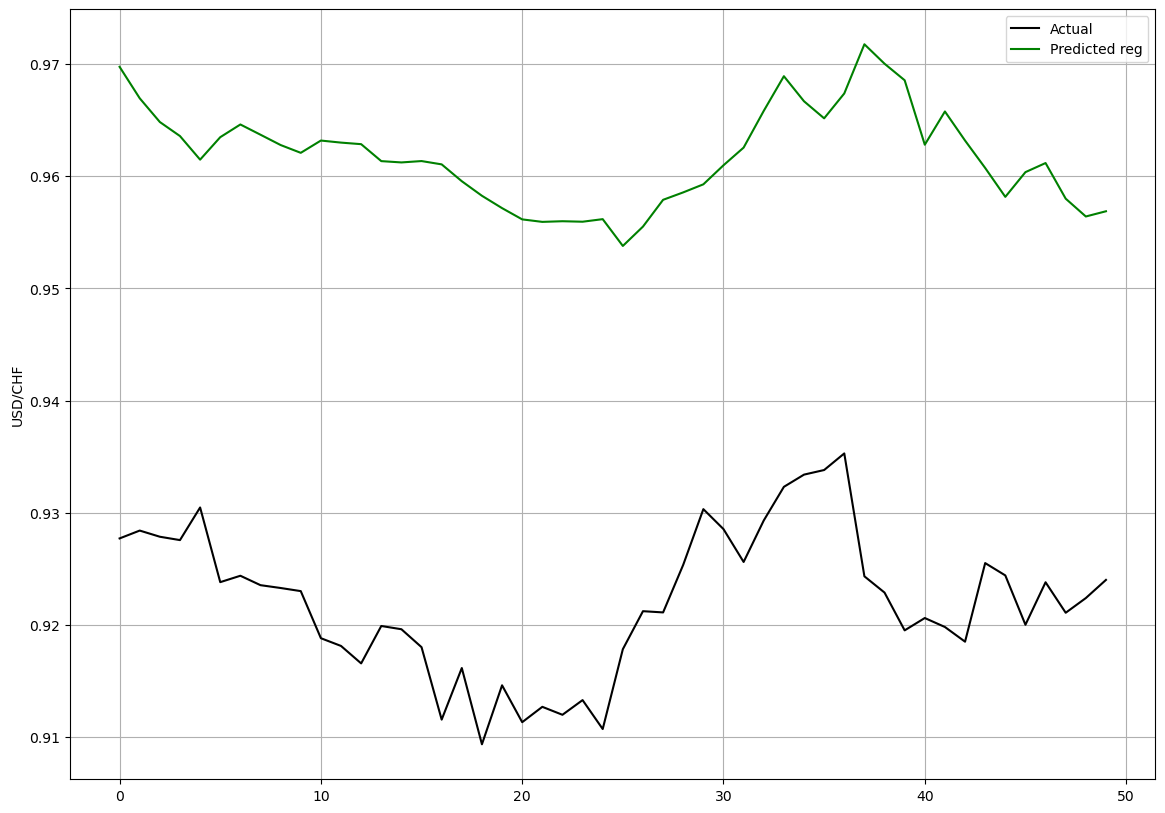

In [66]:
points = range(300,350)
# points = range(len(outputs1))

plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
plt.plot(outputs1[points], "-", color="g", label="Predicted reg")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(targets1[points],"-", color="k", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()

#######
plt.figure(figsize=(14,10))
plt.plot(targets1[points],"-", color="k", label="Actual")
plt.plot(outputs1[points], "-", color="g", label="Predicted reg")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()
# plt.savefig("Figures/Test_Predictions_Rate&IR_NN.png")

# Representation rates from log return

In [364]:
# print(train_y_rate.shape)
# print(outputs1.shape)
# if log_return:
#     reg_rate = train_y_rate.reshape(-1,1)*np.exp(outputs1)
# print(reg_rate.shape)

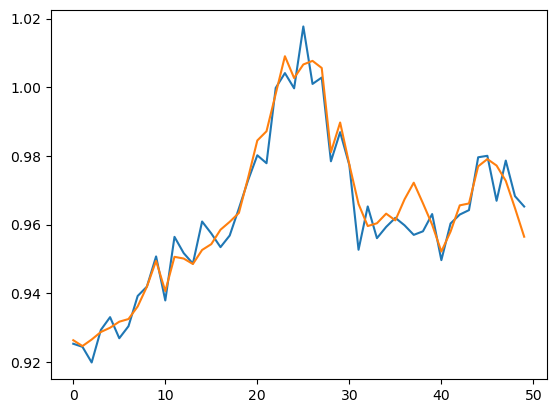

In [303]:
plt.figure()
plt.plot(reg_rate[0:50])
plt.plot(train_y_rate[0:50])